In [1]:
import polars as pl
import numpy as np
from datetime import datetime, timedelta
import random


# Machine learing lib
import torch
import torch.nn as nn
import torch.optim as optim
import research


# visualization
import altair as alt
import binance_local as binance

In [2]:
research.set_seed(42)

In [3]:
# Trading pair symbol
sym = 'BTCUSDT'
# time horizon of time series (time interval)
time_interval = '1h'
# Max number of auto-regressive lags
max_lags = 4
# Forecast horizon in steps 
forecast_horizon = 1
# Sharpe annualized rate (so it's independent of time frequency)
annualized_rate = research.sharpe_annualization_factor(time_interval, 365, 24)

In [4]:
# old version that's in the video that should no longer used
# binance.download_trades(sym, hist_data_window)

# new version that downloads just the data showed in the video
start_date = datetime(2024, 10, 29, 0, 0)
end_date = datetime(2025, 10, 22, 0, 0)
binance.download_date_range(sym, start_date, end_date)

In [5]:
ts = research.load_ohlc_timeseries_range(sym, time_interval, start_date, end_date)
ts

Loading BTCUSDT: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [02:39<00:00,  2.25day/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6
…,…,…,…,…
2025-10-22 19:00:00,107987.7,108379.3,107491.8,107829.0
2025-10-22 20:00:00,107829.1,108032.0,107453.9,107644.4
2025-10-22 21:00:00,107644.4,107694.6,106588.0,107159.8


Loading BTCUSDT: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [03:02<00:00,  1.97day/s]


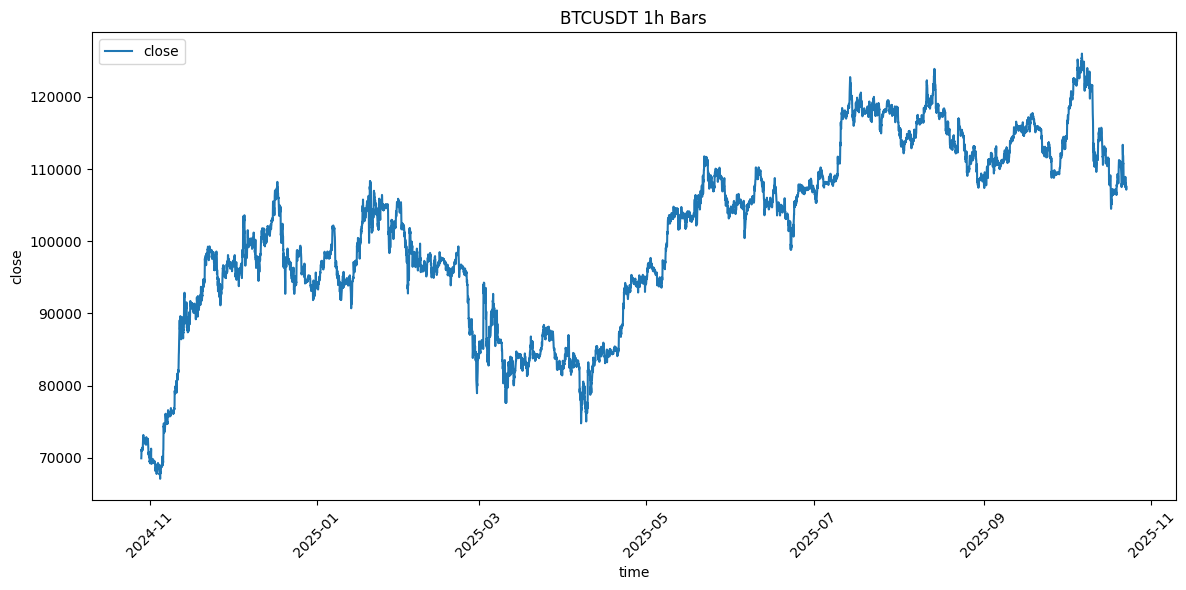

In [6]:
research.load_timeseries_range(sym, time_interval, start_date, end_date, pl.col('price').quantile(0.5).alias('price_median'))
research.plot_static_timeseries(ts, sym, 'close', time_interval)

In [76]:
alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym, 'close', time_interval)

alt.Chart(...)

In [77]:
price_time_series = pl.DataFrame({'price':[100.0,120.0,100.0]})
research.plot_column(price_time_series, 'price')

alt.Chart(...)

In [78]:

price_time_series.with_columns(
    pl.col('price').diff().alias('delta'),
    ((pl.col('price')-pl.col('price').shift())/pl.col('price').shift()).alias('return'),
    (pl.col('price')/pl.col('price').shift()).log().alias('log_return'),
)

price,delta,return,log_return
f64,f64,f64,f64
100.0,null,null,null
120.0,20.0,0.2,0.182322
100.0,-20.0,-0.166667,-0.182322


In [79]:
ts = ts.with_columns((pl.col('close')/pl.col('close').shift(forecast_horizon)).log().alias('close_log_return'))
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2,null,null,null,null
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9,0.019121,null,null,null
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5,0.005025,0.019121,null,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8,-0.006824,0.005025,0.019121,null
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8,-0.002578,-0.006824,0.005025,0.019121
…,…,…,…,…,…,…,…,…
2025-10-21 08:00:00,108019.9,113480.0,107432.8,113355.2,0.04821,-0.022427,-0.005499,-0.000424
2025-10-21 16:00:00,113355.2,113940.0,108000.0,108253.7,-0.046049,0.04821,-0.022427,-0.005499
2025-10-22 00:00:00,108253.8,108649.4,107558.1,108284.1,0.000281,-0.046049,0.04821,-0.022427


In [80]:
target = 'close_log_return'
lr = pl.col(target)
ts = ts.with_columns(
    lr.shift(forecast_horizon * 1).alias(f'{target}_lag_1'),
    lr.shift(forecast_horizon * 2).alias(f'{target}_lag_2'),
    lr.shift(forecast_horizon * 3).alias(f'{target}_lag_3'),
    lr.shift(forecast_horizon * 4).alias(f'{target}_lag_4'),
)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2,null,null,null,null,null
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9,0.019121,null,null,null,null
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5,0.005025,0.019121,null,null,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8,-0.006824,0.005025,0.019121,null,null
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8,-0.002578,-0.006824,0.005025,0.019121,null
…,…,…,…,…,…,…,…,…,…
2025-10-21 08:00:00,108019.9,113480.0,107432.8,113355.2,0.04821,-0.022427,-0.005499,-0.000424,0.023122
2025-10-21 16:00:00,113355.2,113940.0,108000.0,108253.7,-0.046049,0.04821,-0.022427,-0.005499,-0.000424
2025-10-22 00:00:00,108253.8,108649.4,107558.1,108284.1,0.000281,-0.046049,0.04821,-0.022427,-0.005499


In [81]:
ts = research.add_lags(ts, target, max_lags, forecast_horizon)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2,null,null,null,null,null
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9,0.019121,null,null,null,null
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5,0.005025,0.019121,null,null,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8,-0.006824,0.005025,0.019121,null,null
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8,-0.002578,-0.006824,0.005025,0.019121,null
…,…,…,…,…,…,…,…,…,…
2025-10-21 08:00:00,108019.9,113480.0,107432.8,113355.2,0.04821,-0.022427,-0.005499,-0.000424,0.023122
2025-10-21 16:00:00,113355.2,113940.0,108000.0,108253.7,-0.046049,0.04821,-0.022427,-0.005499,-0.000424
2025-10-22 00:00:00,108253.8,108649.4,107558.1,108284.1,0.000281,-0.046049,0.04821,-0.022427,-0.005499


In [82]:
ts = ts.drop_nulls()

In [83]:
# Building of the model
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.network(x)

In [84]:
# Complexity of the  model
input_features = 1

linear_model = MLPModel(input_features)

research.print_model_info(linear_model, "Linear Model")
research.total_model_params(linear_model)


Linear Model

Architecture:
  MLPModel(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

Parameter Count:
  Total parameters:      4,353
  Trainable parameters:  4,353



4353

In [85]:
features = ['close_log_return_lag_1']
target = 'close_log_return'
test_size = 0.25

split_idx = int(len(ts) * (1 - test_size))

ts_train, ts_test = ts[:split_idx],  ts[split_idx:]


In [86]:
ts_train

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-30 16:00:00,72058.8,72984.9,71631.6,72349.0,0.004019,-0.002578,-0.006824,0.005025,0.019121
2024-10-31 00:00:00,72349.0,72598.5,72030.5,72417.8,0.00095,0.004019,-0.002578,-0.006824,0.005025
2024-10-31 08:00:00,72417.8,72720.3,70453.1,70638.7,-0.024874,0.00095,0.004019,-0.002578,-0.006824
2024-10-31 16:00:00,70638.6,70922.4,69705.0,70321.9,-0.004495,-0.024874,0.00095,0.004019,-0.002578
2024-11-01 00:00:00,70321.9,70500.0,68870.4,69301.0,-0.014624,-0.004495,-0.024874,0.00095,0.004019
…,…,…,…,…,…,…,…,…,…
2025-07-24 00:00:00,118713.4,119265.4,117050.2,118368.0,-0.002915,0.001538,0.001723,-0.013987,0.009158
2025-07-24 08:00:00,118368.1,119469.9,117773.1,119074.1,0.005948,-0.002915,0.001538,0.001723,-0.013987
2025-07-24 16:00:00,119074.1,119376.9,118112.0,118294.3,-0.00657,0.005948,-0.002915,0.001538,0.001723


In [87]:
# Make sure features and target are aligned
ts_train = ts_train.drop_nans(subset=features + [target])
ts_test  = ts_test.drop_nans(subset=features + [target])

# Now create tensors
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(ts_train[features]), dtype=torch.float32)
X_test  = torch.tensor(scaler.transform(ts_test[features]), dtype=torch.float32)

y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32).view(-1, 1)
y_test  = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32).view(-1, 1)

# Check shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



torch.Size([804, 1]) torch.Size([804, 1])
torch.Size([268, 1]) torch.Size([268, 1])


In [88]:
y_train.shape
y_test.shape

torch.Size([268, 1])

In [89]:

research.timeseries_train_test_split(ts, features, target, test_size)

(tensor([[-2.5779e-03],
         [ 4.0192e-03],
         [ 9.5049e-04],
         [-2.4874e-02],
         [-4.4949e-03],
         [-1.4624e-02],
         [ 1.1537e-03],
         [ 1.6489e-03],
         [ 4.5597e-03],
         [-6.0213e-03],
         [-3.9492e-04],
         [-1.4097e-02],
         [-4.6838e-03],
         [ 1.0034e-02],
         [-2.3514e-03],
         [ 1.9969e-04],
         [-1.1439e-02],
         [ 1.5240e-02],
         [ 1.0677e-02],
         [-3.7735e-03],
         [ 5.7202e-02],
         [ 1.1558e-02],
         [ 1.7219e-02],
         [-1.0372e-02],
         [ 1.6989e-02],
         [-2.9248e-03],
         [ 4.0992e-03],
         [ 3.3068e-03],
         [ 7.7041e-04],
         [ 5.4508e-04],
         [-2.8555e-03],
         [ 4.8294e-03],
         [ 2.8074e-02],
         [ 1.1059e-02],
         [ 8.4287e-03],
         [ 9.1349e-03],
         [ 3.5902e-02],
         [ 5.3410e-02],
         [ 4.1221e-03],
         [-2.7716e-02],
         [ 1.5027e-02],
         [-6.490

In [90]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)





print("X_train NaNs:", torch.isnan(X_train).sum().item())
print("X_train Infs:", torch.isinf(X_train).sum().item())
print("y_train NaNs:", torch.isnan(y_train).sum().item())
print("y_train Infs:", torch.isinf(y_train).sum().item())


torch.Size([804, 1]) torch.Size([804, 1])
torch.Size([268, 1]) torch.Size([268, 1])
X_train NaNs: 0
X_train Infs: 0
y_train NaNs: 0
y_train Infs: 0


In [91]:
# hyperparameters
no_epochs = 1000 * 5
lr = 0.00001



print(len(features))
# create model
model = MLPModel(len(features))

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.train()
# loss function
criterion = nn.MSELoss()
# optimizer

print("\nTraining model...")

for epoch in range(no_epochs):
    # forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)


    # backward pass
    optimizer.zero_grad()   # 1. clear old gradients
    loss.backward()         # 2. compute new gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()        # 3. update weights

    # check for improvement
    train_loss = loss.item()

    # logging
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss:.6f}")

print("\nLearned parameters")

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data.numpy()}")

# Evaluation
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    print(f"\nTest Loss: {test_loss.item():.6f}, Train Loss: {train_loss:.6f}")

1

Training model...
Epoch [500/5000], Loss: 0.000874
Epoch [1000/5000], Loss: 0.000298
Epoch [1500/5000], Loss: 0.000241
Epoch [2000/5000], Loss: 0.000218
Epoch [2500/5000], Loss: 0.000206
Epoch [3000/5000], Loss: 0.000202
Epoch [3500/5000], Loss: 0.000199
Epoch [4000/5000], Loss: 0.000197
Epoch [4500/5000], Loss: 0.000197
Epoch [5000/5000], Loss: 0.000196

Learned parameters
network.0.weight:
[[-0.9680975 ]
 [-0.27780584]
 [ 0.79245716]
 [ 0.0962872 ]
 [-0.37863612]
 [ 0.4763738 ]
 [ 0.14875299]
 [ 0.39546835]
 [ 1.0028332 ]
 [ 0.02760072]
 [ 0.13432394]
 [-0.81336856]
 [ 0.10527398]
 [ 0.8862999 ]
 [ 0.54836243]
 [-0.7683385 ]
 [ 0.44612685]
 [-0.18957435]
 [-0.48475972]
 [-0.3511719 ]
 [ 0.6767184 ]
 [ 0.9802769 ]
 [-0.37968653]
 [ 0.6214216 ]
 [ 0.7480323 ]
 [-0.1674433 ]
 [-0.8423371 ]
 [-0.8211916 ]
 [-0.06590307]
 [ 0.1962903 ]
 [-0.42747596]
 [-0.02733936]
 [-0.34844932]
 [ 0.8267031 ]
 [ 0.01445238]
 [-0.23063885]
 [ 0.5646641 ]
 [ 0.01630502]
 [-0.56498325]
 [ 0.4568278 ]
 [

In [92]:
def get_linear_params_reg(model: nn.Module):
    """
    Extract weights and biases from all Linear layers in an MLP-style model.
    Returns a tuple (weights, biases), each as a list of numpy arrays.
    """
    weights = []
    biases = []
    
    # If the model has a Sequential container called 'network'
    if hasattr(model, "network"):
        layers = model.network
    else:
        # fallback: iterate all submodules
        layers = model.modules()
    
    for layer in layers:
        if isinstance(layer, nn.Linear):
            weights.append(layer.weight.detach().cpu().numpy())
            biases.append(layer.bias.detach().cpu().numpy())
    
    return weights, biases



def benchmark_reg_model_here(df: pl.DataFrame, features: list[str], target: str, model: nn.Module, annualized_rate, test_size=0.25, loss = None, optimizer = None, no_epochs = None, log = False, lr = None):
    df_train, df_test = research.timeseries_split(df, test_size=test_size)
    if no_epochs is None:
        no_epochs = 6000
    X_train, y_train = torch.tensor(df_train[features].to_numpy(), dtype=torch.float32), torch.tensor(df_train[target].to_numpy(), dtype=torch.float32).reshape(-1, 1)
    X_test, y_test = torch.tensor(df_test[features].to_numpy(), dtype=torch.float32), torch.tensor(df_test[target].to_numpy(),dtype=torch.float32).reshape(-1, 1)
    
    y_hat = research.batch_train_reg(model, X_train, X_test, y_train, y_test, no_epochs, loss, optimizer, lr = lr, logging = log)
    
    perf = research.eval_model_performance(y_test, y_hat, features, target, annualized_rate)
    
    weights, biases = get_linear_params_reg(model)
    perf['weights'] = str(weights)
    perf['biases'] = str(biases)
    
    return perf

In [93]:
perf = benchmark_reg_model_here(ts, features, target, model, annualized_rate)
perf

{'features': 'close_log_return_lag_1',
 'target': 'close_log_return',
 'no_trades': 268,
 'win_rate': 0.5597014925373134,
 'avg_win': 0.007394714196101025,
 'avg_loss': -0.007747949404709566,
 'best_trade': 0.04820985719561577,
 'worst_trade': -0.05397023260593414,
 'ev': 0.0007274220136545702,
 'std': 0.010820540599524975,
 'total_log_return': 0.19494909048080444,
 'compound_return': np.float64(1.2152491171666175),
 'max_drawdown': -0.13279865682125092,
 'equity_trough': 0.005053095519542694,
 'equity_peak': 0.21238279342651367,
 'sharpe': np.float64(6.2920118805856715),
 'weights': '[array([[-0.9668816 ],\n       [-0.27780584],\n       [ 0.79245716],\n       [ 0.0967446 ],\n       [-0.37863612],\n       [ 0.4763738 ],\n       [ 0.14900061],\n       [ 0.39598554],\n       [ 1.0028332 ],\n       [ 0.02765473],\n       [ 0.13432394],\n       [-0.8135444 ],\n       [ 0.10527398],\n       [ 0.8865437 ],\n       [ 0.54836243],\n       [-0.7680341 ],\n       [ 0.44612685],\n       [-0.18887

In [97]:
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),
    'y': y_test.squeeze()
}).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal'),
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.00052,0.016257,true,1.0,0.016257,0.016257
0.000131,-0.002515,false,1.0,-0.002515,0.013742
0.001383,0.006992,true,1.0,0.006992,0.020734
0.000793,-0.001881,false,1.0,-0.001881,0.018853
0.000755,0.001648,true,1.0,0.001648,0.020501
…,…,…,…,…,…
-0.000038,0.04821,false,-1.0,-0.04821,-0.209637
0.002367,-0.046049,false,1.0,-0.046049,-0.255685
0.010301,0.000281,true,1.0,0.000281,-0.255405


In [98]:
research.plot_column(trade_results, 'equity_curve')
# Issue with something that I did'nt installed but I think as we can see  in the view that we are not gaining any thing here

alt.Chart(...)

In [100]:
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.00052,0.016257,true,1.0,0.016257,0.016257,0.0
0.000131,-0.002515,false,1.0,-0.002515,0.013742,-0.002515
0.001383,0.006992,true,1.0,0.006992,0.020734,0.0
0.000793,-0.001881,false,1.0,-0.001881,0.018853,-0.001881
0.000755,0.001648,true,1.0,0.001648,0.020501,-0.000233
…,…,…,…,…,…,…
-0.000038,0.04821,false,-1.0,-0.04821,-0.209637,-0.249433
0.002367,-0.046049,false,1.0,-0.046049,-0.255685,-0.295482
0.010301,0.000281,true,1.0,0.000281,-0.255405,-0.295201


In [101]:
max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.2959931492805481

In [102]:
drawdown_pct = np.exp(max_drawdown_log) - 1
drawdown_pct

np.float64(-0.2562074764833653)

In [103]:
equity_peak = 1000
equity_peak * drawdown_pct

np.float64(-256.20747648336527)

In [104]:
win_rate = trade_results['is_won'].mean()

In [105]:
win_rate
# we have a win rate which is smaller than 0.5 which means that we are more loosing than winning. Not a good model....

0.4664179104477612

In [106]:
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss
ev

-0.0009269948713113286

In [35]:
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

0.2516734302043915

In [36]:
compound_return = np.exp(total_log_return)
compound_return

np.float64(1.2861759424787846)

In [37]:
equity_trough = trade_results['equity_curve'].min()
equity_trough

-0.023526472970843315

In [38]:
equity_peak = trade_results['equity_curve'].max()
equity_peak

0.31204894185066223

In [39]:
research.eval_model_performance(y_test, y_hat, features, target, annualized_rate)

{'features': 'close_log_return_lag_1',
 'target': 'close_log_return',
 'no_trades': 2153,
 'win_rate': 0.5197398978169996,
 'avg_win': 0.0024358488599196745,
 'avg_loss': -0.0023926899907073334,
 'best_trade': 0.03395244851708412,
 'worst_trade': -0.018205415457487106,
 'ev': 0.00011689429812296033,
 'std': 0.003620029892772436,
 'total_log_return': 0.2516734302043915,
 'compound_return': np.float64(1.2861759424787846),
 'max_drawdown': -0.12269395589828491,
 'equity_trough': -0.023526472970843315,
 'equity_peak': 0.31204894185066223,
 'sharpe': np.float64(3.0222697474932523)}

In [43]:
import itertools

benchmarks = []
feature_pool = [f'{target}_lag_{i}' for i in range(1, max_lags + 1)]
combos = list(itertools.combinations(feature_pool, 1))

for features in combos:    
    model = MLPModel(len(features))
    benchmarks.append(research.benchmark_reg_model(ts, list(features), target, model, annualized_rate, test_size=test_size, no_epochs=200, loss=nn.L1Loss()))

benchmark = pl.DataFrame(benchmarks)
benchmark.sort('sharpe', descending=True)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_3""","""close_log_return""",2153,0.499768,0.00245,-0.00238,0.033952,-0.022376,0.000034,0.003622,0.072809,1.075525,-0.183767,-0.153917,0.149596,0.873923,"""[array([[ 0.17809261], …","""[array([ 0.42854416, -0.839048…"
"""close_log_return_lag_2""","""close_log_return""",2153,0.500232,0.002421,-0.002409,0.033952,-0.020861,0.000007,0.003622,0.015199,1.015315,-0.222225,-0.052623,0.202827,0.182426,"""[array([[-0.86424303], …","""[array([ 0.32095474, 0.497441…"
"""close_log_return_lag_1""","""close_log_return""",2153,0.484905,0.002467,-0.002361,0.029018,-0.033952,-0.00002,0.003619,-0.042251,0.958629,-0.182322,-0.172122,0.0102,-0.507498,"""[array([[ 0.5468996 ], …","""[array([ 0.61642087, -0.963439…"
"""close_log_return_lag_4""","""close_log_return""",2153,0.490014,0.00238,-0.002449,0.029018,-0.033952,-0.000083,0.003621,-0.178699,0.836357,-0.28682,-0.194598,0.092222,-2.14539,"""[array([[-0.89783096], …","""[array([ 0.00720614, 0.828601…"


In [44]:
research.auto_reg_corr_matrx(ts, target, max_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
f64,f64,f64,f64,f64
1.0,-0.017178,0.009252,-0.024517,0.012365
-0.017178,1.0,-0.017206,0.009439,-0.024442
0.009252,-0.017206,1.0,-0.017416,0.009354
-0.024517,0.009439,-0.017416,1.0,-0.017153
0.012365,-0.024442,0.009354,-0.017153,1.0


In [45]:
features = ['close_log_return_lag_2']
model = MLPModel(len(features))
model_trades = research.learn_model_trades(ts, features, target, model, no_epochs=200, loss=nn.L1Loss())

research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [46]:
maker_fee = 0.0001
taker_fee = 0.0003

roundtrip_fee_log = np.log(1 - 2 * taker_fee)

model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
model_trades = model_trades.with_columns((pl.col('trade_log_return') + pl.col('tx_fee_log')).alias('trade_log_return_net'))
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))

model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64
0.00024,0.000291,true,1.0,0.000291,0.000291,0.0,-0.0006,-0.00031,-0.00031
0.000145,-0.000817,false,1.0,-0.000817,-0.000527,-0.000817,-0.0006,-0.001418,-0.001727
0.000071,0.007185,true,1.0,0.007185,0.006659,0.0,-0.0006,0.006585,0.004858
0.000107,0.002171,true,1.0,0.002171,0.00883,0.0,-0.0006,0.001571,0.006429
-0.000156,0.001951,false,-1.0,-0.001951,0.006879,-0.001951,-0.0006,-0.002551,0.003878
…,…,…,…,…,…,…,…,…,…
0.000213,-0.001472,false,1.0,-0.001472,-0.05747,-0.204439,-0.0006,-0.002072,-1.347257
0.000006,-0.001713,false,1.0,-0.001713,-0.059184,-0.206152,-0.0006,-0.002314,-1.349571
0.000129,-0.004512,false,1.0,-0.004512,-0.063696,-0.210664,-0.0006,-0.005112,-1.354683


In [47]:
research.plot_column(model_trades, 'equity_curve_net')

alt.Chart(...)

In [48]:
!pip install "vl-convert-python>=1.6.0"

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try 'pacman -S
    python-xyz', where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Arch-packaged Python package,
    create a virtual environment using 'python -m venv path/to/venv'.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-Arch packaged Python application,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. Make sure you have python-pipx
    installed via pacman.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detailed specification.


In [49]:
research.plot_column(model_trades, 'equity_curve_net')

alt.Chart(...)

In [50]:
model_trades['is_won'].mean()

0.5053413841151881

In [51]:
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net,trade_log_return_net_maker,trade_log_return_net_taker,equity_curve_net_maker,equity_curve_net_taker
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64
0.00024,0.000291,true,1.0,0.000291,0.000291,0.0,-0.0006,-0.00031,-0.00031,-9.21005,-8.111437,-9.21005,-8.111437
0.000145,-0.000817,false,1.0,-0.000817,-0.000527,-0.000817,-0.0006,-0.001418,-0.001727,-9.211158,-8.112545,-18.421208,-16.223983
0.000071,0.007185,true,1.0,0.007185,0.006659,0.0,-0.0006,0.006585,0.004858,-9.203155,-8.104543,-27.624363,-24.328526
0.000107,0.002171,true,1.0,0.002171,0.00883,0.0,-0.0006,0.001571,0.006429,-9.208169,-8.109557,-36.832532,-32.438082
-0.000156,0.001951,false,-1.0,-0.001951,0.006879,-0.001951,-0.0006,-0.002551,0.003878,-9.212292,-8.113679,-46.044823,-40.551762
…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.000213,-0.001472,false,1.0,-0.001472,-0.05747,-0.204439,-0.0006,-0.002072,-1.347257,-9.211812,-8.1132,-19793.078929,-17432.161121
0.000006,-0.001713,false,1.0,-0.001713,-0.059184,-0.206152,-0.0006,-0.002314,-1.349571,-9.212054,-8.113442,-19802.290983,-17440.274563
0.000129,-0.004512,false,1.0,-0.004512,-0.063696,-0.210664,-0.0006,-0.005112,-1.354683,-9.214852,-8.11624,-19811.505836,-17448.390803


In [52]:
time_interval = '8h'
ts = research.load_ohlc_timeseries_range(sym, time_interval, start_date, end_date)
ts

Loading BTCUSDT: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [02:49<00:00,  2.11day/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8
…,…,…,…,…
2025-10-21 08:00:00,108019.9,113480.0,107432.8,113355.2
2025-10-21 16:00:00,113355.2,113940.0,108000.0,108253.7
2025-10-22 00:00:00,108253.8,108649.4,107558.1,108284.1


In [53]:
no_lags = 3
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2,null,null,null,null
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9,0.019121,null,null,null
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5,0.005025,0.019121,null,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8,-0.006824,0.005025,0.019121,null
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8,-0.002578,-0.006824,0.005025,0.019121
…,…,…,…,…,…,…,…,…
2025-10-21 08:00:00,108019.9,113480.0,107432.8,113355.2,0.04821,-0.022427,-0.005499,-0.000424
2025-10-21 16:00:00,113355.2,113940.0,108000.0,108253.7,-0.046049,0.04821,-0.022427,-0.005499
2025-10-22 00:00:00,108253.8,108649.4,107558.1,108284.1,0.000281,-0.046049,0.04821,-0.022427


In [54]:
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.HuberLoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",269,0.550186,0.007307,-0.007814,0.04821,-0.05397,0.000505,0.010815,0.135902,1.14557,-0.16843,-0.024409,0.193052,4.372184,"""[array([[-0.03461572]], dtype=…","""[array([0.00060797], dtype=flo…"
"""close_log_return_lag_3""","""close_log_return""",269,0.531599,0.007206,-0.007909,0.04821,-0.05397,0.000126,0.010826,0.033913,1.034495,-0.180149,-0.023952,0.156197,1.089915,"""[array([[-0.05930929]], dtype=…","""[array([0.00062634], dtype=flo…"
"""close_log_return_lag_2""","""close_log_return""",269,0.527881,0.007066,-0.008059,0.04821,-0.05397,-0.000075,0.010827,-0.02005,0.98015,-0.177344,-0.048823,0.128521,-0.644341,"""[array([[-0.03404887]], dtype=…","""[array([0.00060903], dtype=flo…"


In [56]:
research.auto_reg_corr_matrx(ts.drop_nulls(), target, no_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
f64,f64,f64,f64
1.0,-0.03947,-0.024263,-0.054349
-0.03947,1.0,-0.039623,-0.024935
-0.024263,-0.039623,1.0,-0.03914
-0.054349,-0.024935,-0.03914,1.0


In [61]:
research.benchmark_reg_model(ts.drop_nulls(), feature_pool, target, model, annualized_rate, loss=nn.MSELoss())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (804x3 and 1x64)

In [105]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.L1Loss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",269,0.561338,0.007369,-0.007748,0.04821,-0.05397,0.000738,0.010802,0.198401,1.219451,-0.132799,0.003451,0.215834,6.390783,"""[-0.05009809]""","""0.0002856440842151642"""
"""close_log_return_lag_3""","""close_log_return""",269,0.524164,0.006941,-0.00819,0.04821,-0.05397,-0.000259,0.010824,-0.069652,0.932719,-0.16843,-0.087987,0.080443,-2.239002,"""[-0.00134411]""","""0.00043429326615296304"""
"""close_log_return_lag_2""","""close_log_return""",269,0.509294,0.00714,-0.007945,0.04821,-0.05397,-0.000262,0.010824,-0.070563,0.931869,-0.244654,-0.070563,0.174091,-2.2683,"""[-0.05992604]""","""0.00033765239641070366"""


In [109]:
features = ['close_log_return_lag_1']
model = MLPModel(len(features))
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss())
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)

print(model_trades)

shape: (269, 11)
┌───────────┬───────────┬────────┬──────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ y_pred    ┆ y_true    ┆ is_won ┆ position ┆ … ┆ trade_log_ ┆ trade_log_ ┆ equity_cur ┆ equity_cu │
│ ---       ┆ ---       ┆ ---    ┆ ---      ┆   ┆ return_net ┆ return_net ┆ ve_net_mak ┆ rve_net_t │
│ f32       ┆ f32       ┆ bool   ┆ f32      ┆   ┆ _maker     ┆ _taker     ┆ er         ┆ aker      │
│           ┆           ┆        ┆          ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
│           ┆           ┆        ┆          ┆   ┆ f64        ┆ f64        ┆ f64        ┆ f64       │
╞═══════════╪═══════════╪════════╪══════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 0.00164   ┆ 0.003451  ┆ true   ┆ 1.0      ┆ … ┆ -9.206889  ┆ -8.108277  ┆ -9.206889  ┆ -8.108277 │
│ 0.000101  ┆ 0.016257  ┆ true   ┆ 1.0      ┆ … ┆ -9.194083  ┆ -8.095471  ┆ -18.400972 ┆ -16.20374 │
│           ┆           ┆        ┆          ┆   ┆            ┆            

In [110]:
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [111]:
research.plot_column(model_trades, 'equity_curve_net_maker')

alt.Chart(...)

In [112]:
time_interval = '12h'
no_lags = 4
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2,null,null,null,null,null
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9,0.019121,null,null,null,null
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5,0.005025,0.019121,null,null,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8,-0.006824,0.005025,0.019121,null,null
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8,-0.002578,-0.006824,0.005025,0.019121,null
…,…,…,…,…,…,…,…,…,…
2025-10-21 08:00:00,108019.9,113480.0,107432.8,113355.2,0.04821,-0.022427,-0.005499,-0.000424,0.023122
2025-10-21 16:00:00,113355.2,113940.0,108000.0,108253.7,-0.046049,0.04821,-0.022427,-0.005499,-0.000424
2025-10-22 00:00:00,108253.8,108649.4,107558.1,108284.1,0.000281,-0.046049,0.04821,-0.022427,-0.005499


In [113]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.MSELoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.548507,0.00736,-0.007781,0.04821,-0.05397,0.000524,0.010832,0.140469,1.150814,-0.188515,-0.022829,0.206705,4.528734,"""[-0.03528055 -0.0359978 ]""","""0.0006243863026611507"""
"""close_log_return_lag_1""","""close_log_return""",268,0.548507,0.007333,-0.007814,0.04821,-0.05397,0.000494,0.010834,0.132451,1.141623,-0.16843,-0.02786,0.1896,4.269652,"""[-0.03521843]""","""0.0006158141768537462"""
"""close_log_return_lag_2,close_l…","""close_log_return""",268,0.541045,0.007312,-0.007831,0.04821,-0.05397,0.000362,0.010839,0.09711,1.101981,-0.149723,-0.04284,0.173381,3.128902,"""[-0.03567574 -0.05964991]""","""0.0006472921231761575"""
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.552239,0.007127,-0.008072,0.04821,-0.05397,0.000321,0.01084,0.086123,1.08994,-0.203786,-0.04284,0.216457,2.774574,"""[-0.03798401 -0.03703791 -0.06…","""0.000671212503220886"""
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.522388,0.007461,-0.007648,0.04821,-0.05397,0.000244,0.010842,0.065497,1.06769,-0.187149,-0.081577,0.105572,2.109701,"""[-0.03587842 -0.06031595]""","""0.0006468737265095115"""
"""close_log_return_lag_3""","""close_log_return""",268,0.529851,0.007232,-0.007909,0.04821,-0.05397,0.000114,0.010844,0.030462,1.03093,-0.180149,-0.027404,0.152745,0.980982,"""[-0.05926593]""","""0.0006325107533484697"""
"""close_log_return_lag_2""","""close_log_return""",268,0.526119,0.007092,-0.008059,0.04821,-0.05397,-0.000088,0.010845,-0.023501,0.976773,-0.177344,-0.052274,0.125069,-0.756813,"""[-0.03364655]""","""0.0006093389820307493"""


In [114]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.HuberLoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.548507,0.00736,-0.007781,0.04821,-0.05397,0.000524,0.010832,0.140469,1.150814,-0.188515,-0.022829,0.206705,4.528734,"""[-0.03519413 -0.0359067 ]""","""0.0006366177112795413"""
"""close_log_return_lag_1""","""close_log_return""",268,0.548507,0.007333,-0.007814,0.04821,-0.05397,0.000494,0.010834,0.132451,1.141623,-0.16843,-0.02786,0.1896,4.269652,"""[-0.03485096]""","""0.0006123814382590353"""
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.552239,0.007127,-0.008072,0.04821,-0.05397,0.000321,0.01084,0.086123,1.08994,-0.203786,-0.04284,0.216457,2.774574,"""[-0.03792759 -0.03695513 -0.06…","""0.0006688098073936999"""
"""close_log_return_lag_2,close_l…","""close_log_return""",268,0.541045,0.007248,-0.007906,0.04821,-0.05397,0.000293,0.010841,0.078531,1.081697,-0.168301,-0.04284,0.173381,2.529806,"""[-0.03152116 -0.06375228]""","""0.0006523775518871844"""
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.522388,0.007461,-0.007648,0.04821,-0.05397,0.000244,0.010842,0.065497,1.06769,-0.187149,-0.081577,0.105572,2.109701,"""[-0.03533089 -0.06127252]""","""0.0006528240628540516"""
"""close_log_return_lag_3""","""close_log_return""",268,0.529851,0.007232,-0.007909,0.04821,-0.05397,0.000114,0.010844,0.030462,1.03093,-0.180149,-0.027404,0.152745,0.980982,"""[-0.05882025]""","""0.0006314545753411949"""
"""close_log_return_lag_2""","""close_log_return""",268,0.526119,0.007092,-0.008059,0.04821,-0.05397,-0.000088,0.010845,-0.023501,0.976773,-0.177344,-0.052274,0.125069,-0.756813,"""[-0.03392334]""","""0.0006146464729681611"""


In [115]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.L1Loss(), test_size=0.25)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.559701,0.007275,-0.0079,0.04821,-0.05397,0.000594,0.010829,0.159068,1.172418,-0.132799,-0.011638,0.176502,5.130055,"""[-0.05381488 -0.00173372]""","""0.00032299719168804586"""
"""close_log_return_lag_1""","""close_log_return""",268,0.55597,0.007312,-0.007848,0.04821,-0.05397,0.000581,0.010829,0.155615,1.168377,-0.132799,-0.031421,0.173049,5.018378,"""[-0.05483229]""","""0.00034082107595168054"""
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.541045,0.007287,-0.00786,0.04821,-0.05397,0.000335,0.01084,0.089837,1.093995,-0.181453,0.002829,0.184282,2.894322,"""[-0.07082979 -0.0801533 -0.00…","""0.00031874183332547545"""
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.526119,0.007292,-0.007837,0.04821,-0.05397,0.000122,0.010844,0.032798,1.033342,-0.205466,-0.054209,0.151256,1.05625,"""[-0.06885266 -0.07817581]""","""0.00035426803515292704"""
"""close_log_return_lag_3""","""close_log_return""",268,0.522388,0.006966,-0.00819,0.04821,-0.05397,-0.000273,0.010842,-0.073103,0.929505,-0.16843,-0.091439,0.076992,-2.354833,"""[0.0018448]""","""0.00045542954467236996"""
"""close_log_return_lag_2""","""close_log_return""",268,0.503731,0.007201,-0.007905,0.04821,-0.05397,-0.000295,0.010841,-0.079159,0.923893,-0.244654,-0.079159,0.165494,-2.550047,"""[-0.06634763]""","""0.00039516526157967746"""
"""close_log_return_lag_2,close_l…","""close_log_return""",268,0.5,0.007138,-0.007963,0.04821,-0.05397,-0.000412,0.010837,-0.110491,0.895394,-0.270655,-0.110491,0.160164,-3.560638,"""[-0.06066899 0.00447161]""","""0.00037919572787359357"""


In [116]:

features = ['close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3']
model = MLPModel(len(features))
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss())
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [91]:
torch.save(model.state_dict(), 'model_weights_reg.pth')